In [52]:
import pandas as pd

# Specify the file path
file_path = '03 - corpus_labeled.tsv'

# Read the TSV file into a pandas DataFrame
df = pd.read_csv(file_path, sep='\t')

# Display the DataFrame
print(df)


                                               sentence          label  \
0     healing takes time, but eventually, our broken...  non-distorted   
1     they have a talent for bringing people togethe...  non-distorted   
2     happiness comes from within, and while having ...  non-distorted   
3     i think that her husband doesn't really mind i...  non-distorted   
4     he should help sometimes as well prepare the d...  non-distorted   
...                                                 ...            ...   
7799  i do believe that everyone deserves the chance...  non-distorted   
7800  make sure you find a therapist you think your ...  non-distorted   
7801            you two must love each other very much.  non-distorted   
7802  as your email only focused on the medical aspe...  non-distorted   
7803  that will give you your best chance of overcom...  non-distorted   

      encoded_label  
0                 0  
1                 0  
2                 0  
3                 0  
4

In [53]:
import requests
import json

# Define the API endpoint for the generate method
OLLAMA_ENDPOINT = "http://localhost:11434/api/generate"
headers = {'Content-Type': 'application/json'}
responses = [] 
# The payload should match the successful curl request

for index, row in df.iterrows():
    sentence = row['sentence']
    payload = {
    "model": "mixtral",  # Specify the correct model identifier
    "temperature": 0.1,
    "prompt": f"I am doing a thesis on discovering Cognitive distortions in the texts of depressed individuals. Cognitive distortions are thoughts that cause individuals to perceive reality inaccurately. I need your help to detect the presence of CDS in some sentences. Any slight of CDS presence should be considered as distorted even the smallest ones. Does the following sentence contain a cognitive distortion: {sentence}? Your answer should be either the word 'non-distorted' or 'distorted'. Nothing else to be included in the response. Do not answer anything other than 'non-distorted' or 'distorted'"
    }
    try:
        # Send the POST request
        response = requests.post(OLLAMA_ENDPOINT, json=payload, headers=headers)
        if response.status_code == 200:
            # Initialize an empty string to collect the full response
            full_response = ""
            # Load each JSON response line and concatenate until 'done' is True
            for line in response.iter_lines():
                if line:  # Check if line is not empty
                    json_line = json.loads(line)
                    full_response += json_line['response']
                    if json_line['done']:
                        break
            print("Full Response:", full_response)
            print(f"Sentence: {sentence}")
        else:
            print("Failed to get a proper response from the model. Status Code:", response.status_code)
            print("Response:", response.text)  # Also print the raw response text in case of HTTP errors
    except Exception as e:
        print("Error during the API call.")
        print(e)
    responses.append((sentence, response_content))

    # Print the response for immediate feedback, if available
    if response_content != "Error":
        print(f"Sentence: {sentence}")
        print("Response: " + response_content)

# After loop completion, convert the list to a DataFrame for easy viewing and analysis
responses_df = pd.DataFrame(responses, columns=['sentence', 'Response'])
# Optionally, save this DataFrame to a CSV file for later review
responses_df.to_csv('responses.csv', index=False)    


Full Response:  Non-distorted. The sentence is a positive and hopeful statement about healing and recovery, which does not contain any cognitive distortions.
Sentence: healing takes time, but eventually, our broken hearts can mend and we can find happiness again.
Full Response:  Non-distorted. The sentence does not contain any cognitive distortions. It is a positive statement, describing someone as having a talent for creating a positive community by bringing people together.
Sentence: they have a talent for bringing people together, and it creates a positive community.
Full Response:  Non-distorted
Sentence: happiness comes from within, and while having a partner can enhance our lives, it's not the only source of joy.
Full Response:  Non-distorted
Sentence: i think that her husband doesn't really mind if she goes or not, it's her choice but she should probably go just to be with him and to make new contacts or friendships.
Full Response:  Distorted.

The sentence shows several cogniti

KeyboardInterrupt: 

In [61]:
!pip install aiofiles




[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import aiohttp
import asyncio
import csv
import os
from tqdm.notebook import tqdm
import aiofiles

OLLAMA_ENDPOINT = "http://localhost:11434/api/generate"
headers = {'Content-Type': 'application/json'}

async def fetch_response(session, sentence):
    payload = {
        "model": "mixtral",
        "temperature": 0.1,
        "prompt": f"I am doing a thesis on discovering Cognitive distortions in the texts of depressed individuals. Cognitive distortions are thoughts that cause individuals to perceive reality inaccurately. I need your help to detect the presence of CDS in some sentences. Any slight of CDS presence should be considered as distorted even the smallest ones. Does the following sentence contain a cognitive distortion: {sentence}? Your answer should be either the word 'non-distorted' or 'distorted'. Nothing else to be included in the response. Do not answer anything other than 'non-distorted' or 'distorted'"
    }
    # Try up to 3 attempts if timeouts occur
    for attempt in range(3):
        try:
            async with session.post(OLLAMA_ENDPOINT, json=payload, headers=headers, timeout=600) as response:  # Increased timeout
                if response.status != 200:
                    return (sentence, "Error during API call", await response.text())
                full_response = ""
                async for line in response.content:
                    if line:
                        json_line = json.loads(line)
                        full_response += json_line['response']
                        if json_line['done']:
                            break
                return (sentence, full_response)
        except asyncio.TimeoutError:
            print(f"Timeout occurred for {sentence}, attempt {attempt + 1}")
            if attempt == 2:
                return (sentence, "Failed after multiple timeout attempts")

async def main():
    file_path = 'responses.csv'
    if not os.path.exists(file_path):
        async with aiofiles.open(file_path, 'w', newline='') as file:
            await file.write(','.join(['Sentence', 'Response']) + '\n')

    async with aiohttp.ClientSession() as session, aiofiles.open(file_path, 'a', newline='') as file:
        tasks = [fetch_response(session, row['sentence']) for index, row in df.iterrows()]
        progress_bar = tqdm(asyncio.as_completed(tasks), total=len(tasks))
        for response in progress_bar:
            sentence, full_response = await response
            await file.write(','.join([sentence, full_response]) + '\n')
            progress_bar.set_description(f"Processed: {sentence}")
            progress_bar.set_postfix_str(f"Response: {full_response[:50]}...")

await main()  # This will directly use the Jupyter-managed asyncio event loop


  0%|          | 0/7804 [00:00<?, ?it/s]

In [28]:
import requests
import pandas as pd

# Define the API endpoint
OLLAMA_ENDPOINT = "http://localhost:11434/api/generate"
headers = {'Content-Type': 'application/json'}

# Ensure your DataFrame 'df' is defined, e.g., by loading it from a CSV
# df = pd.read_csv('path_to_your_csv.csv')  # Uncomment and modify this line to load your sentences

responses = []  # Initialize an empty list to store the responses

for index, row in df.iterrows():
    sentence = row['sentence']
    payload = {
    "model": "mixtral",  # Specify the correct model identifier
    "prompt": f"I am doing a thesis on discovering Cognitive distortions in the texts of depressed individuals. Cognitive distortions are thoughts that cause individuals to perceive reality inaccurately. I need your help to detect the presence of CDS in some sentences. Any slight of CDS presence should be considered as distorted even the smallest ones. Does the following sentence contain a cognitive distortion: {sentence}? Your answer should be either the word 'non-distorted' or 'distorted'. Nothing else to be included in the response."
}    
    try:
        response = requests.post(OLLAMA_ENDPOINT, json=payload, headers=headers)
        
        if response.status_code == 200:
            response_data = response.json()
            response_content = response_data['choices'][0]['message']['content'].strip()
        else:
            response_content = "Error"
    except Exception as e:
        print(f"Error processing sentence: {sentence}")
        print(e)
        response_content = "Error"

    responses.append((sentence, response_content))

    # Print the response for immediate feedback, if available
    if response_content != "Error":
        print(f"Sentence: {sentence}")
        print("Response: " + response_content)

# After loop completion, convert the list to a DataFrame for easy viewing and analysis
responses_df = pd.DataFrame(responses, columns=['sentence', 'Response'])
# Optionally, save this DataFrame to a CSV file for later review
responses_df.to_csv('responses.csv', index=False)


Error processing sentence: healing takes time, but eventually, our broken hearts can mend and we can find happiness again.
Extra data: line 2 column 1 (char 99)
Error processing sentence: they have a talent for bringing people together, and it creates a positive community.
Extra data: line 2 column 1 (char 99)
Error processing sentence: happiness comes from within, and while having a partner can enhance our lives, it's not the only source of joy.
Extra data: line 2 column 1 (char 99)
Error processing sentence: i think that her husband doesn't really mind if she goes or not, it's her choice but she should probably go just to be with him and to make new contacts or friendships.
Extra data: line 2 column 1 (char 99)
Error processing sentence: he should help sometimes as well prepare the dinner and not only count on me all the time! i wish he would see how busy i am everyday and cannot expect me to be 100% perfect/reactive/careful all the time.
Extra data: line 2 column 1 (char 99)
Error p

KeyboardInterrupt: 

Accuracy: 0.8105954055321144
Recall: 0.7468531468531469
Precision: 0.9621621621621622
F1 Score: 0.8409448818897638
Confusion Matrix:
 [[1068  362]
 [  42  661]]


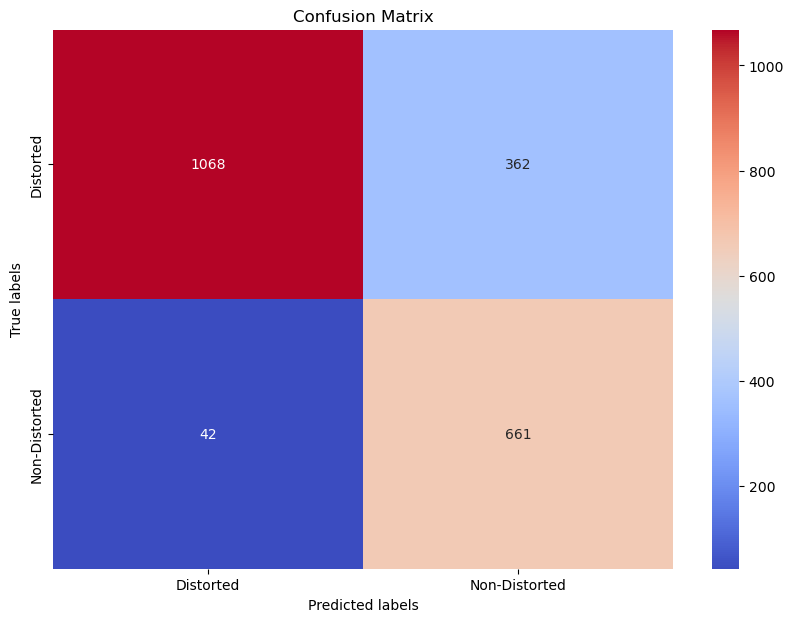

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Load the CSV files into DataFrames
file_path = 'C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/02 - therapistQA_labeled.tsv'
df_labels = pd.read_csv(file_path, sep='\t')
df_responses = pd.read_csv('C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/therapistQA_labeled_GPT4turbo.csv')

# Drop rows where Response is None in df_responses
df_responses.dropna(subset=['Response'], inplace=True)
# Merge the DataFrames on the sentence column
df_merged = pd.merge(df_labels, df_responses, on='sentence')

# Calculate metrics
accuracy = accuracy_score(df_merged['label'], df_merged['Response'])
recall = recall_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
precision = precision_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
f1 = f1_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
conf_matrix = confusion_matrix(df_merged['label'], df_merged['Response'], labels=['distorted', 'non-distorted'])

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:\n', conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=['Distorted', 'Non-Distorted'], yticklabels=['Distorted', 'Non-Distorted'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.9337356972211744
Recall: 0.8594973217964565
Precision: 0.9181338028169014
F1 Score: 0.8878484783996595
Confusion Matrix:
 [[2086  341]
 [ 186 5340]]


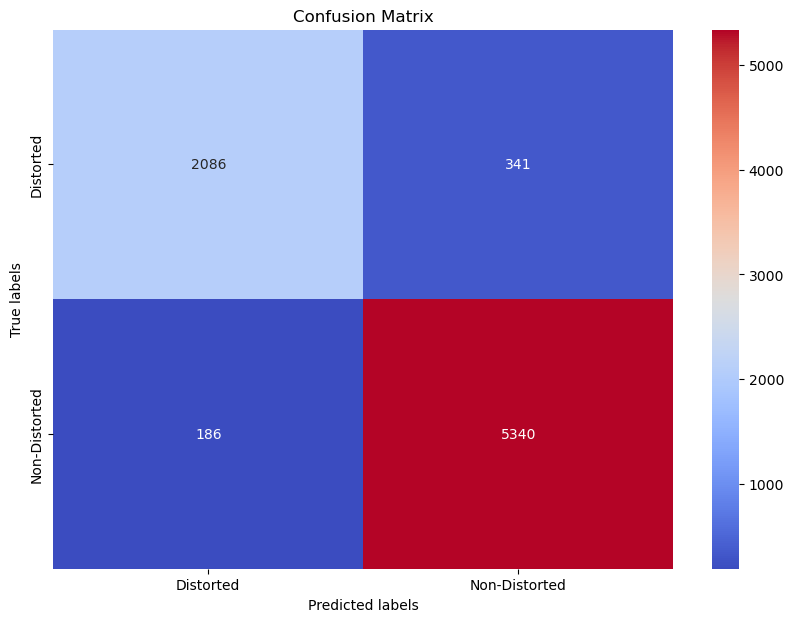

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Load the CSV files into DataFrames
file_path = 'C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/03 - corpus_labeled.tsv'
df_labels = pd.read_csv(file_path, sep='\t')
df_responses = pd.read_csv('C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/corpus_labeled_GPT4turbo.csv')

# Drop rows where Response is None in df_responses
df_responses.dropna(subset=['Response'], inplace=True)
# Merge the DataFrames on the sentence column
df_merged = pd.merge(df_labels, df_responses, on='sentence')

# Calculate metrics
accuracy = accuracy_score(df_merged['label'], df_merged['Response'])
recall = recall_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
precision = precision_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
f1 = f1_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
conf_matrix = confusion_matrix(df_merged['label'], df_merged['Response'], labels=['distorted', 'non-distorted'])

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:\n', conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=['Distorted', 'Non-Distorted'], yticklabels=['Distorted', 'Non-Distorted'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [1]:
import pandas as pd

# Assume 'data' is your dataframe after loading the image text into it, with columns 'non-distorted' and 'distorted'
file_path = 'C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/01 - Books and Online Resources.tsv'
data = pd.read_csv(file_path, sep='\t')
# Split the 'non-distorted' and 'distorted' columns into two separate DataFrames
df_non_distorted = data['non-distorted'].str.split('\n', expand=True).stack().reset_index(drop=True).to_frame(name='sentence')
df_distorted = data['distorted'].str.split('\n', expand=True).stack().reset_index(drop=True).to_frame(name='sentence')

# Assign labels to each sentence
df_non_distorted['label'] = 'non-distorted'
df_distorted['label'] = 'distorted'

# Concatenate both DataFrames into one
df_final = pd.concat([df_non_distorted, df_distorted], axis=0).reset_index(drop=True)

# Output the final DataFrame
print(df_final)


                                               sentence          label
0     Healing takes time, but eventually, our broken...  non-distorted
1     They have a talent for bringing people togethe...  non-distorted
2     Happiness comes from within, and while having ...  non-distorted
3     I think that her husband doesn't really mind i...  non-distorted
4     He should help sometimes as well prepare the d...  non-distorted
...                                                 ...            ...
5686  A parent saw their child making mistakes and a...      distorted
5687  A person observed their coworker taking freque...      distorted
5688  A person saw someone with a different cultural...      distorted
5689  A person saw someone with a physical disabilit...      distorted
5690  A person observed their coworker making a mist...      distorted

[5691 rows x 2 columns]


In [4]:
import os
from dotenv import load_dotenv
import openai
import time
import pandas as pd  # Assuming you're using pandas DataFrame for `df`.

# Load environment variables
load_dotenv()

# Initialize the AzureOpenAI client
client = openai.AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint="https://genai-nexus.api.corpinter.net/apikey/",
    api_key=os.getenv('NEXUS_API_KEY'),
)

batch_size = 999  # Number of sentences to process before pausing
pause_duration = 5  # Pause duration in seconds

responses = []  # Initialize an empty list to store the responses

for index, row in df_final.iterrows():
    sentence = row['sentence']
    
    try:
        # Prepare the message with the sentence from the dataframe
        messages = [
            {
                "role": "user",
                "content": f"""I am engaged in a research project aimed at identifying cognitive distortions in the textual expressions of individuals with depression. Cognitive distortions are erroneous thought patterns that significantly distort an individual’s perception of reality, often leading to negative thinking and emotional distress. These distortions include but are not limited to:

All-or-nothing thinking: Viewing situations in only two categories instead of on a continuum.
Overgeneralization: Making broad interpretations from a single or few events.
Mental filter: Focusing exclusively on the negatives and ignoring positives.
Disqualifying the positive: Rejecting positive experiences as flukes.
Jumping to conclusions: Making negative interpretations without evidence.
Magnification and minimization: Exaggerating negatives and understating positives.
Emotional reasoning: Believing that what one feels must be true.
Should statements: Using rigid rules on how oneself or others should behave.
Labeling and mislabeling: Assigning global negative labels to oneself or others.
Personalization: Assuming responsibility for events outside one's control.
Given the sentence: {sentence}, please analyze it for the presence of any of the aforementioned cognitive distortions. Consider even the slightest indication of a cognitive distortion as significant. Respond with 'distorted' if any cognitive distortions are detected, or 'non-distorted' if none are present. Do not reply anything else other than 'distorted' or 'non-distorted'. If it cannot be answered with either of these words then reply with just 'non-distorted' .""",
            },
        ]
         # Call the API
        completion = client.chat.completions.create(
            model="gpt4-turbo",
            messages=messages,
            temperature=0,  # Adjust for creativity.
            max_tokens=50,  # Maximum length of the output.
            top_p=0.1,  # Nucleus sampling.
            frequency_penalty=0,  # Penalize new tokens based on their frequency in the text so far.
            presence_penalty=0,  # Penalize new tokens based on whether they appear in the text so far.
            stop=None,  # Sequence(s) at which the model will stop generating further text.
            logit_bias={},  # Example to discourage a specific token. Adjust the token ID and bias according to needs.
        )
        response_content = completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error processing sentence: {sentence}")
        print(e)
        response_content = None  # Set the response to None in case of an error
    
    # Store the response in the list, regardless of whether there was an error or not
    responses.append((sentence, response_content))
    
    # Print the response for immediate feedback, if available
    if response_content is not None:
        print(f"Sentence: {sentence}")
        print("Response: " + response_content)
    
    # Check if we've hit the batch size and if so, pause
    if (index + 1) % batch_size == 0:
        print(f"Processed {index + 1} sentences, taking a {pause_duration}-second break...")
        time.sleep(pause_duration)

# After loop completion, convert the list to a DataFrame for easy viewing and analysis
responses_df = pd.DataFrame(responses, columns=['sentence', 'Response'])
# Optionally, save this DataFrame to a CSV file for later review
responses_df.to_csv('responses.csv', index=False)


Sentence: Healing takes time, but eventually, our broken hearts can mend and we can find happiness again.
Response: non-distorted
Sentence: They have a talent for bringing people together, and it creates a positive community.
Response: non-distorted
Sentence: Happiness comes from within, and while having a partner can enhance our lives, it's not the only source of joy.
Response: non-distorted
Sentence: I think that her husband doesn't really mind if she goes or not, it's her choice but she should probably go just to be with him and to make new contacts or friendships.
Response: non-distorted
Sentence: He should help sometimes as well prepare the dinner and not only count on me all the time! I wish he would see how busy I am everyday and cannot expect me to be 100% perfect/reactive/careful all the time.
Response: distorted
Sentence: I now know the problem I need to solve and so I can research how to solve the problem such as high protein and caloric foods that will speed up her weight g

Accuracy: 0.9667183997240903
Recall: 0.9657258064516129
Precision: 0.8576544315129812
F1 Score: 0.9084874348032242
Confusion Matrix:
 [[ 958   34]
 [ 159 4648]]


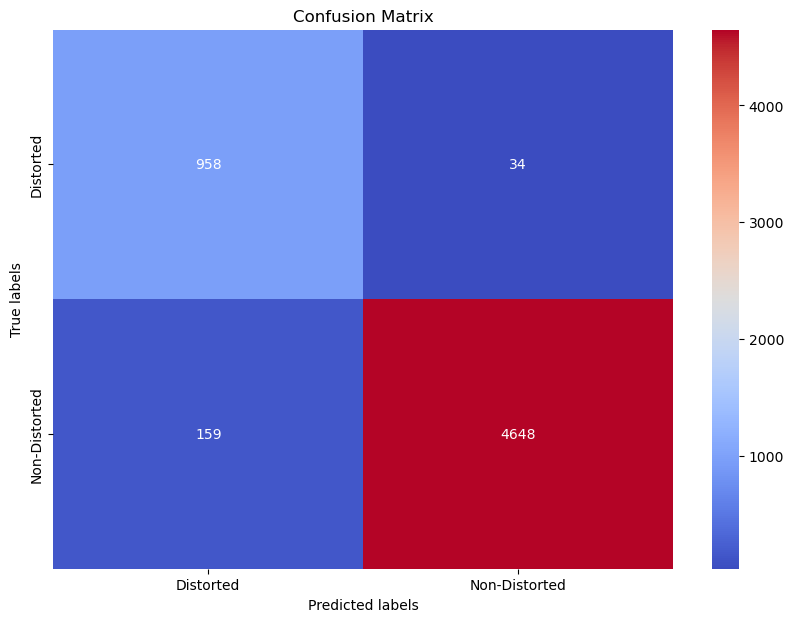

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Load the CSV files into DataFrames
# file_path = 'C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/03 - corpus_labeled.tsv'
df_labels = df_final
df_responses = pd.read_csv('C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/BooksOnlineGPT4turbofiltered_betterprompt.csv')

# Drop rows where Response is None in df_responses
df_responses.dropna(subset=['Response'], inplace=True)
# Merge the DataFrames on the sentence column
df_merged = pd.merge(df_labels, df_responses, on='sentence')

# Calculate metrics
accuracy = accuracy_score(df_merged['label'], df_merged['Response'])
recall = recall_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
precision = precision_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
f1 = f1_score(df_merged['label'], df_merged['Response'], pos_label='distorted')
conf_matrix = confusion_matrix(df_merged['label'], df_merged['Response'], labels=['distorted', 'non-distorted'])

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:\n', conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=['Distorted', 'Non-Distorted'], yticklabels=['Distorted', 'Non-Distorted'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [5]:
df_merged.to_csv('C:/Users/ZACHARS/Desktop/Thesis/1000 - Data/BooksOnlineGPT4turbo_merged.csv', index=False)